In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, utils
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from pyfaidx import Fasta


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/tmp/ipykernel_2418329/2781717483.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


In [3]:
fig_out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures"

# Read in ICGC Data

In [4]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


In [7]:
icgc_methyl_age_df_t['dataset'].unique()

array(['PACA', 'UTCA', 'PAEN', 'PRAD', 'OV', 'PBCA', 'CLLE'], dtype=object)

In [6]:
icgc_mut_w_age_df['case_submitter_id'].nunique()

655

In [5]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
# distance
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/comparison_sites*")
m_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/mean_metrics*")

In [6]:
# all metrics
"""icgc_dist_all_metrics_dfs = []
for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    # subset to only mutated sites
    one_metrics_df = one_metrics_df.loc[one_metrics_df["mutated_sample"] == True]
    icgc_dist_all_metrics_dfs.append(one_metrics_df)
icgc_dist_all_metrics_df = pd.concat(icgc_dist_all_metrics_dfs)
icgc_dist_all_metrics_df.reset_index(inplace=True, drop=True)"""

# write to one parquet file
#icgc_dist_all_metrics_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_all_metrics_no_matchedSample.parquet')
icgc_dist_all_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_all_metrics_no_matchedSample.parquet')

In [9]:
# mean metrics
icgc_dist_mean_metrics_df_l = []
for path in m_paths:
    # read in metrics sites from dask paruet
    one_metrics_df = pd.read_parquet(path)
    icgc_dist_mean_metrics_df_l.append(one_metrics_df)
icgc_dist_mean_metrics_df = pd.concat(icgc_dist_mean_metrics_df_l)

In [7]:
#icgc_dist_mean_metrics_w_annot_df = analyze_comethylation.add_mutation_info_to_mean_metrics_df(icgc_dist_mean_metrics_df, distance = 10000, consortium = 'ICGC')
#icgc_dist_mean_metrics_w_annot_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_mean_metrics10kDist.parquet')icgc_dist_mean_metrics_w_annot_df
icgc_dist_mean_metrics_w_annot_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_mean_metrics10kDist.parquet')

In [ ]:
# comparison sites
icgc_dist_all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    icgc_dist_all_comparison_site_dfs.append(one_comp_df)
icgc_dist_all_comparison_site_df = pd.concat(icgc_dist_all_comparison_site_dfs)
icgc_dist_all_comparison_site_df.reset_index(inplace=True, drop=True)

# A)KDE plot and B) ratio

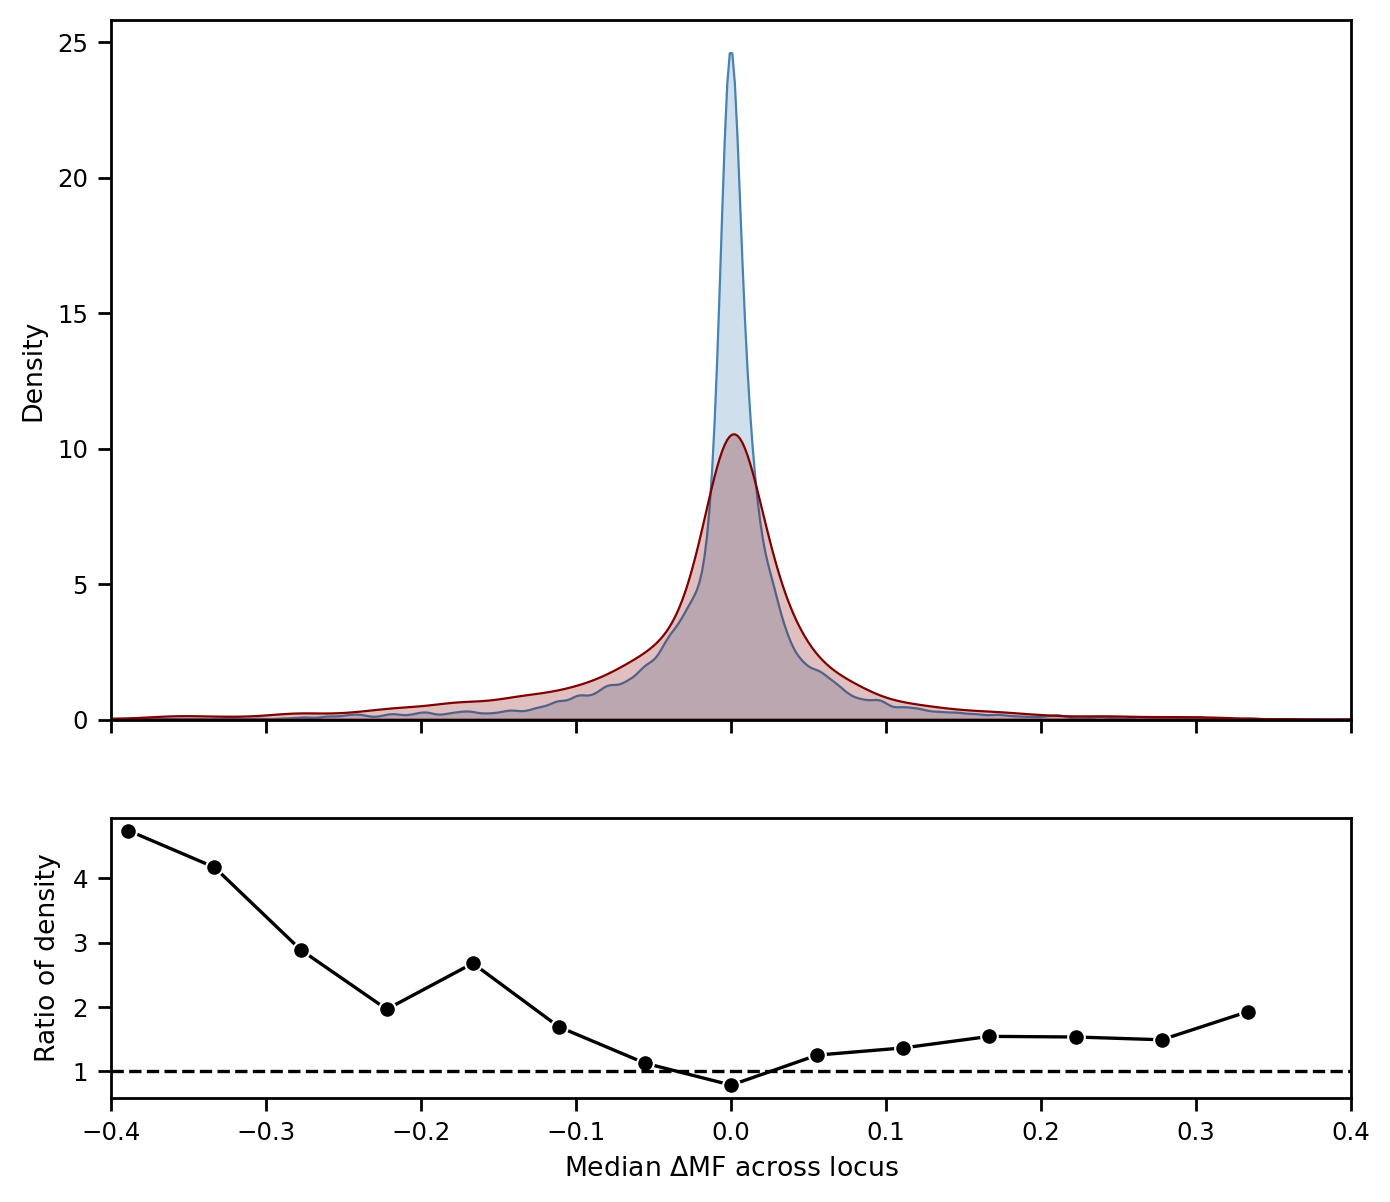

In [29]:
# make second axes bigger kw
fig, axes = plt.subplots(
    2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True
    )
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    icgc_dist_mean_metrics_w_annot_df,
    metric = 'median_dmf', axes = axes,
    consortium = 'ICGC', out_fn = os.path.join(fig_out_dir, 'figure3', 'figure3a_icgc_median_dmf_kde.svg')
    ) # set minimum ratio value to 15

# C) Distance of effect

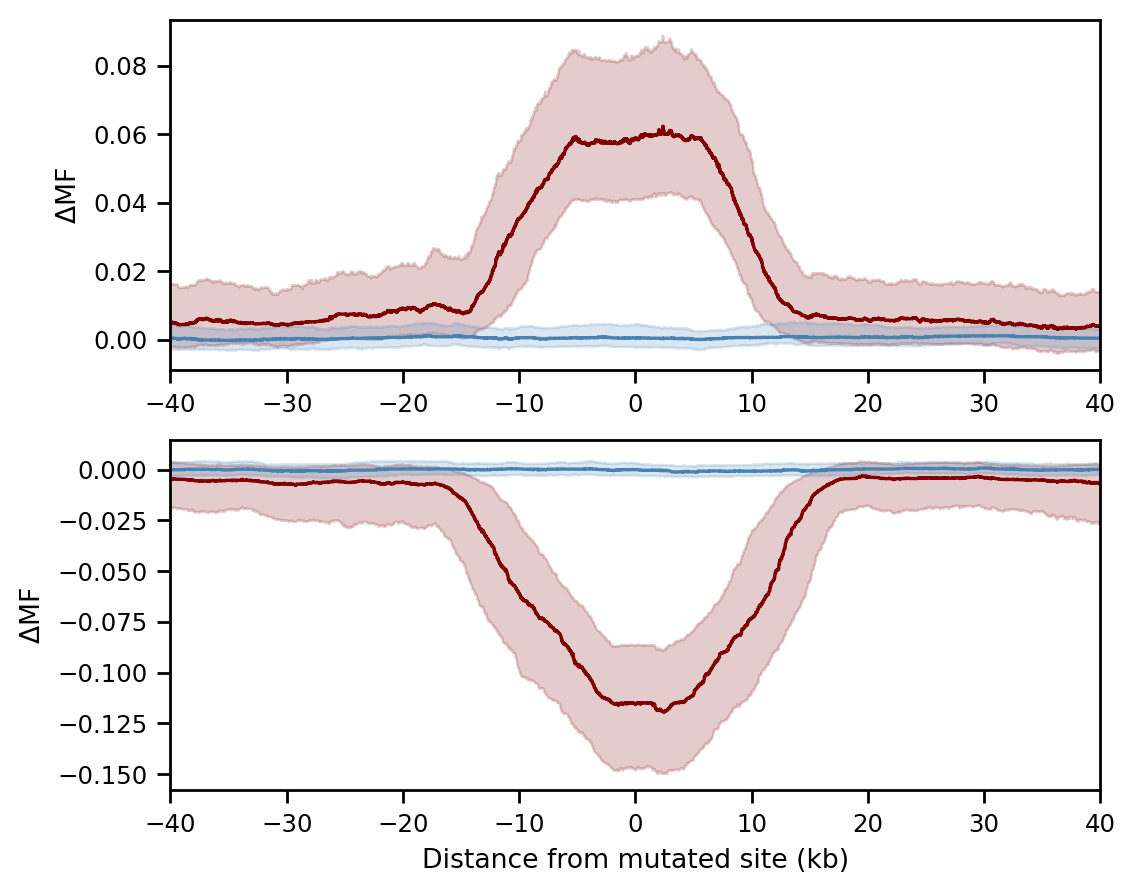

In [27]:
# 
fig, axes = analyze_comethylation.plot_distance_of_effect_lineplot( # smoothing_window_size_dist -2000
    icgc_dist_mean_metrics_df, icgc_dist_all_metrics_df, num_top_muts = 1000,
    smoothing_window_size_dist = 2000, smoothing_window_size_corr = 300,
    corr_vs_dist = False, illumina_cpg_locs_df = illumina_cpg_locs_df,
    dist = 10000, plot_bg = True, out_fn = os.path.join(fig_out_dir, 'figure3', 'figure3C_icgc_distance_of_effect_lineplot_rasterized.svg')
    )

In [25]:
fig.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3C_icgc_distance_of_effect_lineplot_new_other.svg'), bbox_inches='tight',  dpi=900)

In [24]:
fig.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3C_icgc_distance_of_effect_lineplot_new_other.png'), bbox_inches='tight',, format = 'png')

# D) boxplots of functional regions

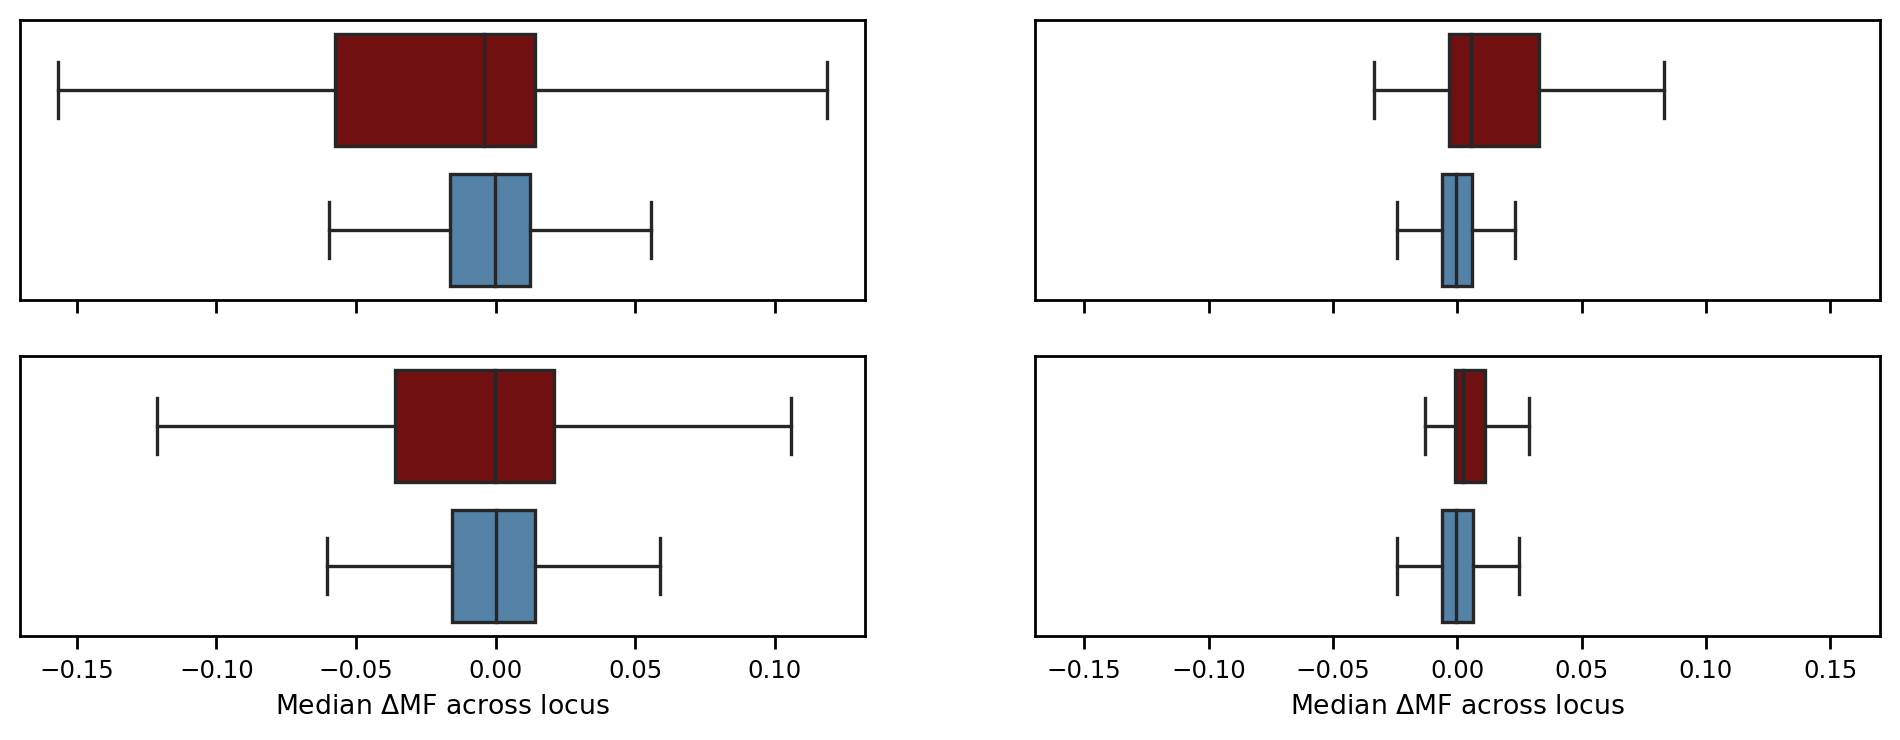

In [30]:
# make second axes bigger kw
fig, axes = plt.subplots(2,2, figsize = (12, 4), dpi = 100, sharex='col')
axes = axes.flatten()
sns.set_context('paper')
###############################################################
# all
###############################################################
# do not show x or y ticks or labels
icgc_dist_mean_metrics_w_annot_df['is_cpg'] = icgc_dist_mean_metrics_w_annot_df['seq'].str.upper().str.contains('CG')
icgc_dist_mean_metrics_w_annot_df['is_cpg'] = icgc_dist_mean_metrics_w_annot_df['is_cpg'].map({True: 'CpG', False: 'Non-CpG'})

icgc_dist_mean_metrics_w_annot_df['is_cgi_renamed'] = icgc_dist_mean_metrics_w_annot_df['is_cgi'].map({True: 'in CGI', False: 'not in CGI'})

icgc_dist_mean_metrics_w_annot_df['combined_category'] = icgc_dist_mean_metrics_w_annot_df['is_cpg'] + '\n' + icgc_dist_mean_metrics_w_annot_df['is_cgi_renamed']

mut = icgc_dist_mean_metrics_w_annot_df.loc[icgc_dist_mean_metrics_w_annot_df.mutated_sample == True]
mut = mut.rename(
    columns={'is_background': 'Locus'}
    ).replace(
                {'Locus': {True: 'Random', False: 'Mutated'}}
                )
  

bins = np.linspace(-.75, .75, 28)
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[0], showfliers=False, order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[2], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[1], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[3], showfliers=False,order = ['Mutated', 'Random'] # bins=bins, stat='probability',
    #element= 'step', kde = True
    )
axes[3].set_xlim(-.17, .17)
for i in range(4):
    axes[i].set_yticklabels([])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticks([])
axes[2].set_xlabel(r'Median $\Delta$MF across locus')
axes[3].set_xlabel(r'Median $\Delta$MF across locus')
plt.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3D_icgc_median_dmf_boxplot.svg'), dpi = 300, format = 'svg')

# Supplementary fig 3: DNA_VAF vs median dmf

SignificanceResult(statistic=0.06757797103048216, pvalue=4.775453144405756e-10)
PearsonRResult(statistic=0.08495957860331807, pvalue=4.764201540277238e-15)


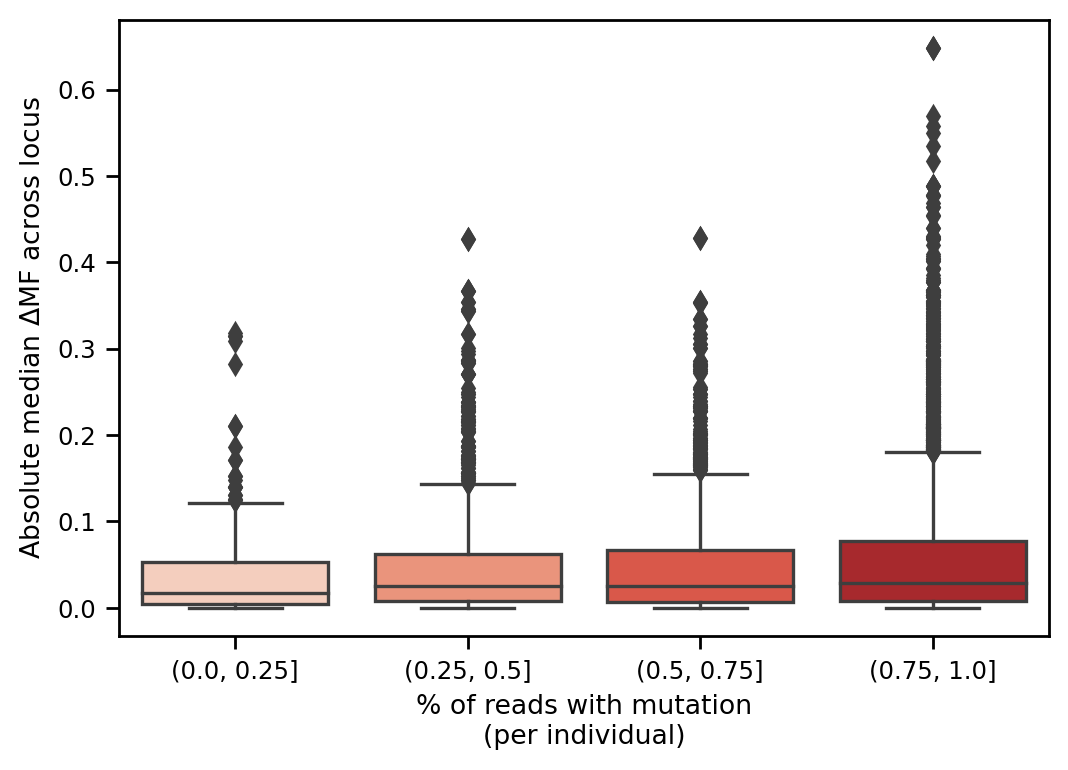

In [31]:
fig, axes = plt.subplots(figsize = (6,4), dpi = 100)
sns.set_context('paper')
# bin by DNA VAF
icgc_dist_mean_metrics_w_annot_df['DNA_VAF_bin'] = pd.cut(
    icgc_dist_mean_metrics_w_annot_df['DNA_VAF'],
    bins = pd.IntervalIndex.from_tuples([(0,.25), (.25, .5), (.5, .75), (.75, 1)])
        #[(0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1)])
    )
# get absolute value of median dmf
icgc_dist_mean_metrics_w_annot_df['abs_median_dmf'] = icgc_dist_mean_metrics_w_annot_df['median_dmf'].abs()
# boxplot
sns.boxplot(
    data=icgc_dist_mean_metrics_w_annot_df.query("is_background == False"),
    x='DNA_VAF_bin', y='abs_median_dmf', showfliers=True, palette = 'Reds',
    ax = axes
    )
# corrs, median_abs_dmf is better than abs_median_dmf
print(spearmanr(icgc_dist_mean_metrics_w_annot_df.query("is_background == False")['DNA_VAF'], icgc_dist_mean_metrics_w_annot_df.query("is_background == False")['median_abs_dmf']))
print(pearsonr(icgc_dist_mean_metrics_w_annot_df.query("is_background == False")['DNA_VAF'], icgc_dist_mean_metrics_w_annot_df.query("is_background == False")['median_abs_dmf']))
axes.set_ylabel('Absolute median $\Delta$MF across locus')
axes.set_xlabel('% of reads with mutation\n(per individual)')
plt.savefig(os.path.join(fig_out_dir, 'supplemental', 'figure3_DNAVAF_vs_absDMF_distance_ICGC.svg'), dpi = 300, format = 'svg')